In [20]:
!pip install -q -r ../requirements.txt


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Define constants and load model:

In [2]:
from tensorflow import keras

model = keras.models.load_model(r"C:\Users\Marco\dev\git\proj-chaotic-pendulum\src\timeseries_forecasting\models\long_model_50_200.h5")
sequence_length = 50
output_length = 200
overall_length = sequence_length + output_length

prediction_path = r'..\src\work_dir\prediction_data'
gif_path = r'..\src\work_dir\output.gif'

## Load Timeseries to predict on

In [3]:
import pandas as pd

data = pd.read_csv(r"C:\Users\Marco\dev\git\proj-chaotic-pendulum\src\work_dir\data.csv", delimiter=",")

## Validate Data correctness with external function

In [14]:
import sys
sys.path.append('../')

from src.timeseries_forecasting.animation.utils.validation_utils import validate_data_correctness

validate_data_correctness(data, overall_length=overall_length)

## Filter and Preprocess data

In [4]:
import numpy as np

# Remove rows with NaN values
data.dropna(inplace=True)

# Cut to the needed length
data = data.iloc[:overall_length, :]

# Convert the angles in sin and cos values, to fit model input
data.loc[:, 'Sin_Angle1'] = np.sin(data['Angle1'])
data.loc[:, 'Cos_Angle1'] = np.cos(data['Angle1'])

data.loc[:, 'Sin_Angle2'] = np.sin(data['Angle2'])
data.loc[:, 'Cos_Angle2'] = np.cos(data['Angle2'])

sin_angle1 = data["Sin_Angle1"].to_numpy()
cos_angle1 = data["Cos_Angle1"].to_numpy()

sin_angle2 = data["Sin_Angle2"].to_numpy()
cos_angle2 = data["Cos_Angle2"].to_numpy()

# Convert them together
numpy_data = np.column_stack((sin_angle1, cos_angle1, sin_angle2, cos_angle2))

# Split data to input and output
x_sample = numpy_data[:sequence_length]
y_sample = numpy_data[sequence_length:sequence_length + output_length].flatten()

prediction_input = np.array(x_sample)
ground_truth_output = np.array(y_sample)

## Reconstruct data from sin and cos values
After the prediction the data will be reconstructed to the original shape

In [5]:
def reconstruct_radian(array: np.ndarray) -> np.ndarray:
    reconstructed1 = np.arctan2(array[:, 0], array[:, 1])
    reconstructed2 = np.arctan2(array[:, 2], array[:, 3])
    return np.column_stack((reconstructed1, reconstructed2))

## Calculate the MSE
Calculate the MSE from groundtruth and prediction for better interpretation

In [6]:
from sklearn.metrics import mean_squared_error
def calculate_mse(groundtruth: np.ndarray, prediction: np.ndarray) -> float:

    mse1 = mean_squared_error(groundtruth[0], prediction[0])
    mse2 = mean_squared_error(groundtruth[1], prediction[1])
    mse = (mse1 + mse2) / 2
    return mse

## Run prediction and reshape data

In [7]:
prediction_output = model.predict(np.expand_dims(prediction_input, axis=0))

prediction_output_reconstructed = reconstruct_radian(prediction_output.reshape(-1, 4))
ground_truth_output_reconstructed = reconstruct_radian(ground_truth_output.reshape(-1, 4))

mse = calculate_mse(groundtruth=ground_truth_output_reconstructed, prediction=prediction_output_reconstructed)

# Add zeros for the non-prediction time
prediction_output = np.concatenate((np.zeros((sequence_length, 2)), prediction_output_reconstructed),
                                         axis=0)

ground_truth_output = np.concatenate(
    (reconstruct_radian(prediction_input), ground_truth_output_reconstructed), axis=0)
print(f"Mean Squared Error: {mse}")

1/1 [==============================] - 2s 2s/step
Mean Squared Error: 0.003969659272280871


## Plot prediction and groundtruth curve

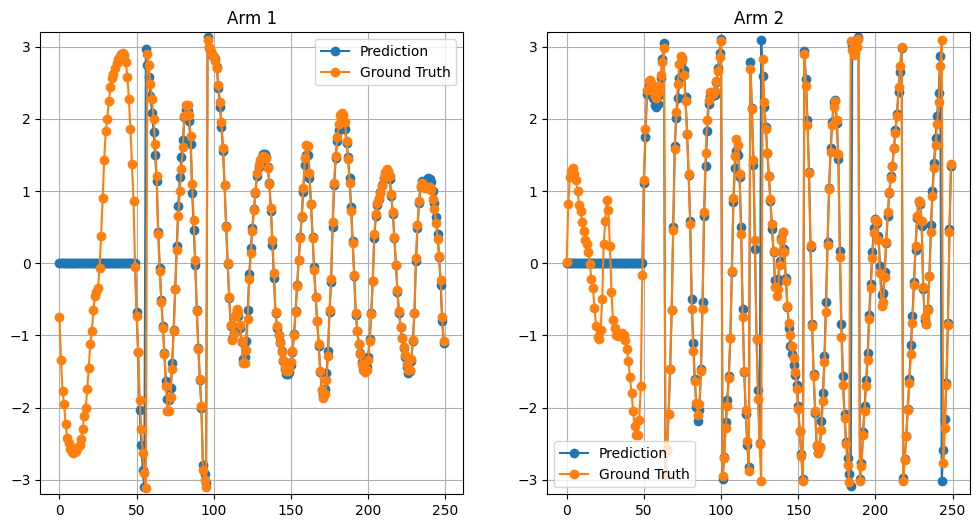

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create a range of values for x-axis
x_values = np.arange(overall_length)

# Arm 1
axes[0].plot(x_values, prediction_output[:, 0], label="Prediction", linestyle='-', marker='o')
axes[0].plot(x_values, ground_truth_output[:, 0], label="Ground Truth", linestyle='-', marker='o')

# Arm 2
axes[1].plot(x_values, prediction_output[:, 1], label="Prediction", linestyle='-', marker='o')
axes[1].plot(x_values, ground_truth_output[:, 1], label="Ground Truth", linestyle='-', marker='o')

# Add titles and legends
for i in range(2):
    axes[i].set_title(f"Arm {i + 1}")
    axes[i].set_ylim([-3.2, 3.2])
    axes[i].legend()
    axes[i].grid(visible=True)

plt.show()

## Calculate and plot deviation

The maximum deviation of Angle 1 is 0.24106282852256644
The maximum deviation of Angle 2 is 0.22492620717212208
The minimum deviation of Angle 1 is 0.0007620394912275508
The minimum deviation of Angle 2 is 0.00020134110290248586
The mean deviation of Angle 1 is 0.051385644545095845
The mean deviation of Angle 2 is 0.06229636307837163
The standard deviation of Angle 1 is 0.05022490607811792
The standard deviation of Angle 2 is 0.047603399477180966


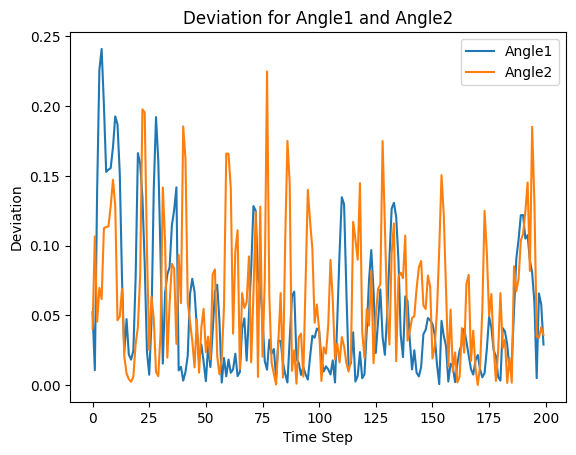

In [9]:
%matplotlib inline

ground_truth_output = ground_truth_output[sequence_length:]
prediction_output = prediction_output[sequence_length:]
deviation = abs(abs(ground_truth_output) - abs(prediction_output))

print(f"The maximum deviation of Angle 1 is {np.max(deviation[:, 0])}")
print(f"The maximum deviation of Angle 2 is {np.max(deviation[:, 1])}")

print(f"The minimum deviation of Angle 1 is {np.min(deviation[:, 0])}")
print(f"The minimum deviation of Angle 2 is {np.min(deviation[:, 1])}")

print(f"The mean deviation of Angle 1 is {np.mean(deviation[:, 0])}")
print(f"The mean deviation of Angle 2 is {np.mean(deviation[:, 1])}")

print(f"The standard deviation of Angle 1 is {np.std(deviation[:, 0])}")
print(f"The standard deviation of Angle 2 is {np.std(deviation[:, 1])}")

# Get the indices for the plot
indices = range(output_length)

# Plot both Angle1 and Angle2 deviation on the same graph
plt.plot(indices, deviation, label=['Angle1', 'Angle2'])

plt.xlabel('Time Step')
plt.ylabel('Deviation')
plt.title('Deviation for Angle1 and Angle2')
plt.legend()
plt.show()

## Plot trajectory
This plot shows a better interpretable way to compare both timeseries by showing the full movement.

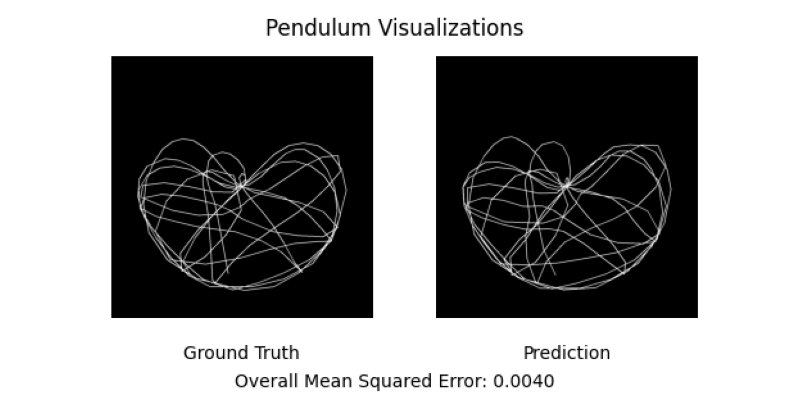

In [16]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import os

from src.timeseries_forecasting.animation.plot_images import run_image_generation_trajectory

run_image_generation_trajectory(ground_truth_output, prediction_output, mse=mse, prediction_path=prediction_path)

img = mpimg.imread(os.path.join(prediction_path, 'trajectory.png'))

fig = plt.figure(figsize=(10, 5))

plt.imshow(img)
plt.axis('off')
plt.show()

## Plot animation of the chaotic pendulums
### Enhance outputs
To display a better understanding of the movement the pendulum shows a slight fade of past values. To make this possible, Every angle line will be enhanced with the last three values before.

In [11]:
def enhance_output_with_past_values(arr: np.ndarray):
    new_shape = (arr.shape[0], arr.shape[1] * 4)
    new_arr = np.zeros(new_shape)

    new_arr[:, :arr.shape[1]] = arr

    for i in range(3, arr.shape[0]):
        for j in range(arr.shape[1]):
            new_arr[i, (j * 3) + arr.shape[1]:(j * 3) + arr.shape[1] + 3] = arr[i - 3:i, j]

    return new_arr

### Generate animation images
To generate the animation multiprocessing has been used, this fastens the process.

In [12]:
from src.timeseries_forecasting.animation.plot_images import generate_image
from multiprocessing import Pool

ground_truth_output = enhance_output_with_past_values(ground_truth_output)
prediction_output = enhance_output_with_past_values(prediction_output)
# Use multiprocessing to generate images in parallel
with Pool() as pool:
    args_list = [(image_index, y_true, y_pred, prediction_path, mse) for image_index, (y_true, y_pred) in
                 enumerate(zip(ground_truth_output, prediction_output))]
    pool.starmap(generate_image, args_list)

print("Process done")

Process done


### Generate gif from animation images
The last step is to generate a gif out of the animation images and display it.

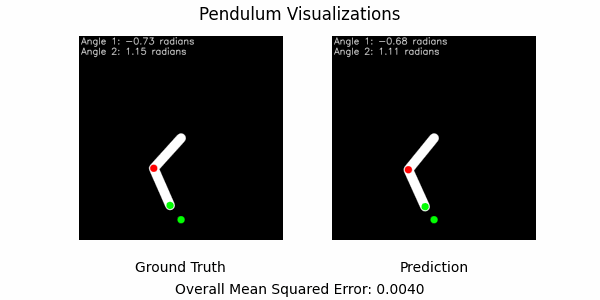

In [19]:
import glob
import tqdm
from PIL import Image
from IPython.display import display, Image as IPImage

# Use glob to find all PNG files in the specified directory
image_paths = glob.glob(os.path.join(prediction_path, '*.png'))

# Create a list to store image objects
images = []

# Open each image and append it to the list
for image_path in image_paths:
    img = Image.open(image_path)
    images.append(img)
    
# Save the GIF
images[0].save(
    gif_path,
    save_all=True,
    append_images=images[1:],
    duration=5,  # Duration between frames in milliseconds
    loop=0,  # 0 means infinite loop
)

# Display the GIF in the Jupyter Notebook
display(IPImage(filename=gif_path, width=800, height=400))